In [22]:
import os
import random
from typing import List, Tuple, Dict

import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

In [23]:
graph_data = pd.read_csv(os.path.join('data', 'harris_ross_network.csv'))
G = nx.from_pandas_edgelist(graph_data, 'source', 'target', ['weight'])

In [24]:
def print_network_stats(G: nx.Graph) -> None:
    num_nodes = G.number_of_nodes()
    print(f"Number of nodes: {num_nodes}")
    
    num_edges = G.number_of_edges()
    print(f"Number of edges: {num_edges}")
    
    degrees = dict(G.degree())
    print("Degrees of each node:")

    avg_degree = sum(degrees.values()) / num_nodes
    print(f"Average degree: {avg_degree:.2f}")

    density = nx.density(G)
    print(f"Density: {density:.4f}")

    avg_clustering_coefficient = nx.average_clustering(G)
    print(f"Average clustering coefficient: {avg_clustering_coefficient:.4f}")

    if nx.is_connected(G):
        diameter = nx.diameter(G)
        print(f"Network Diameter: {diameter}")
    else:
        print("Diameter: Graph is not connected")

    if nx.is_connected(G):
        avg_shortest_path_length = nx.average_shortest_path_length(G)
        print(f"Average shortest path length: {avg_shortest_path_length:.2f}")
    else:
        print("Average shortest path length: Graph is not connected")

print_network_stats(G)

Number of nodes: 42
Number of edges: 91
Degrees of each node:
Average degree: 4.33
Density: 0.1057
Average clustering coefficient: 0.4364
Network Diameter: 8
Average shortest path length: 3.55


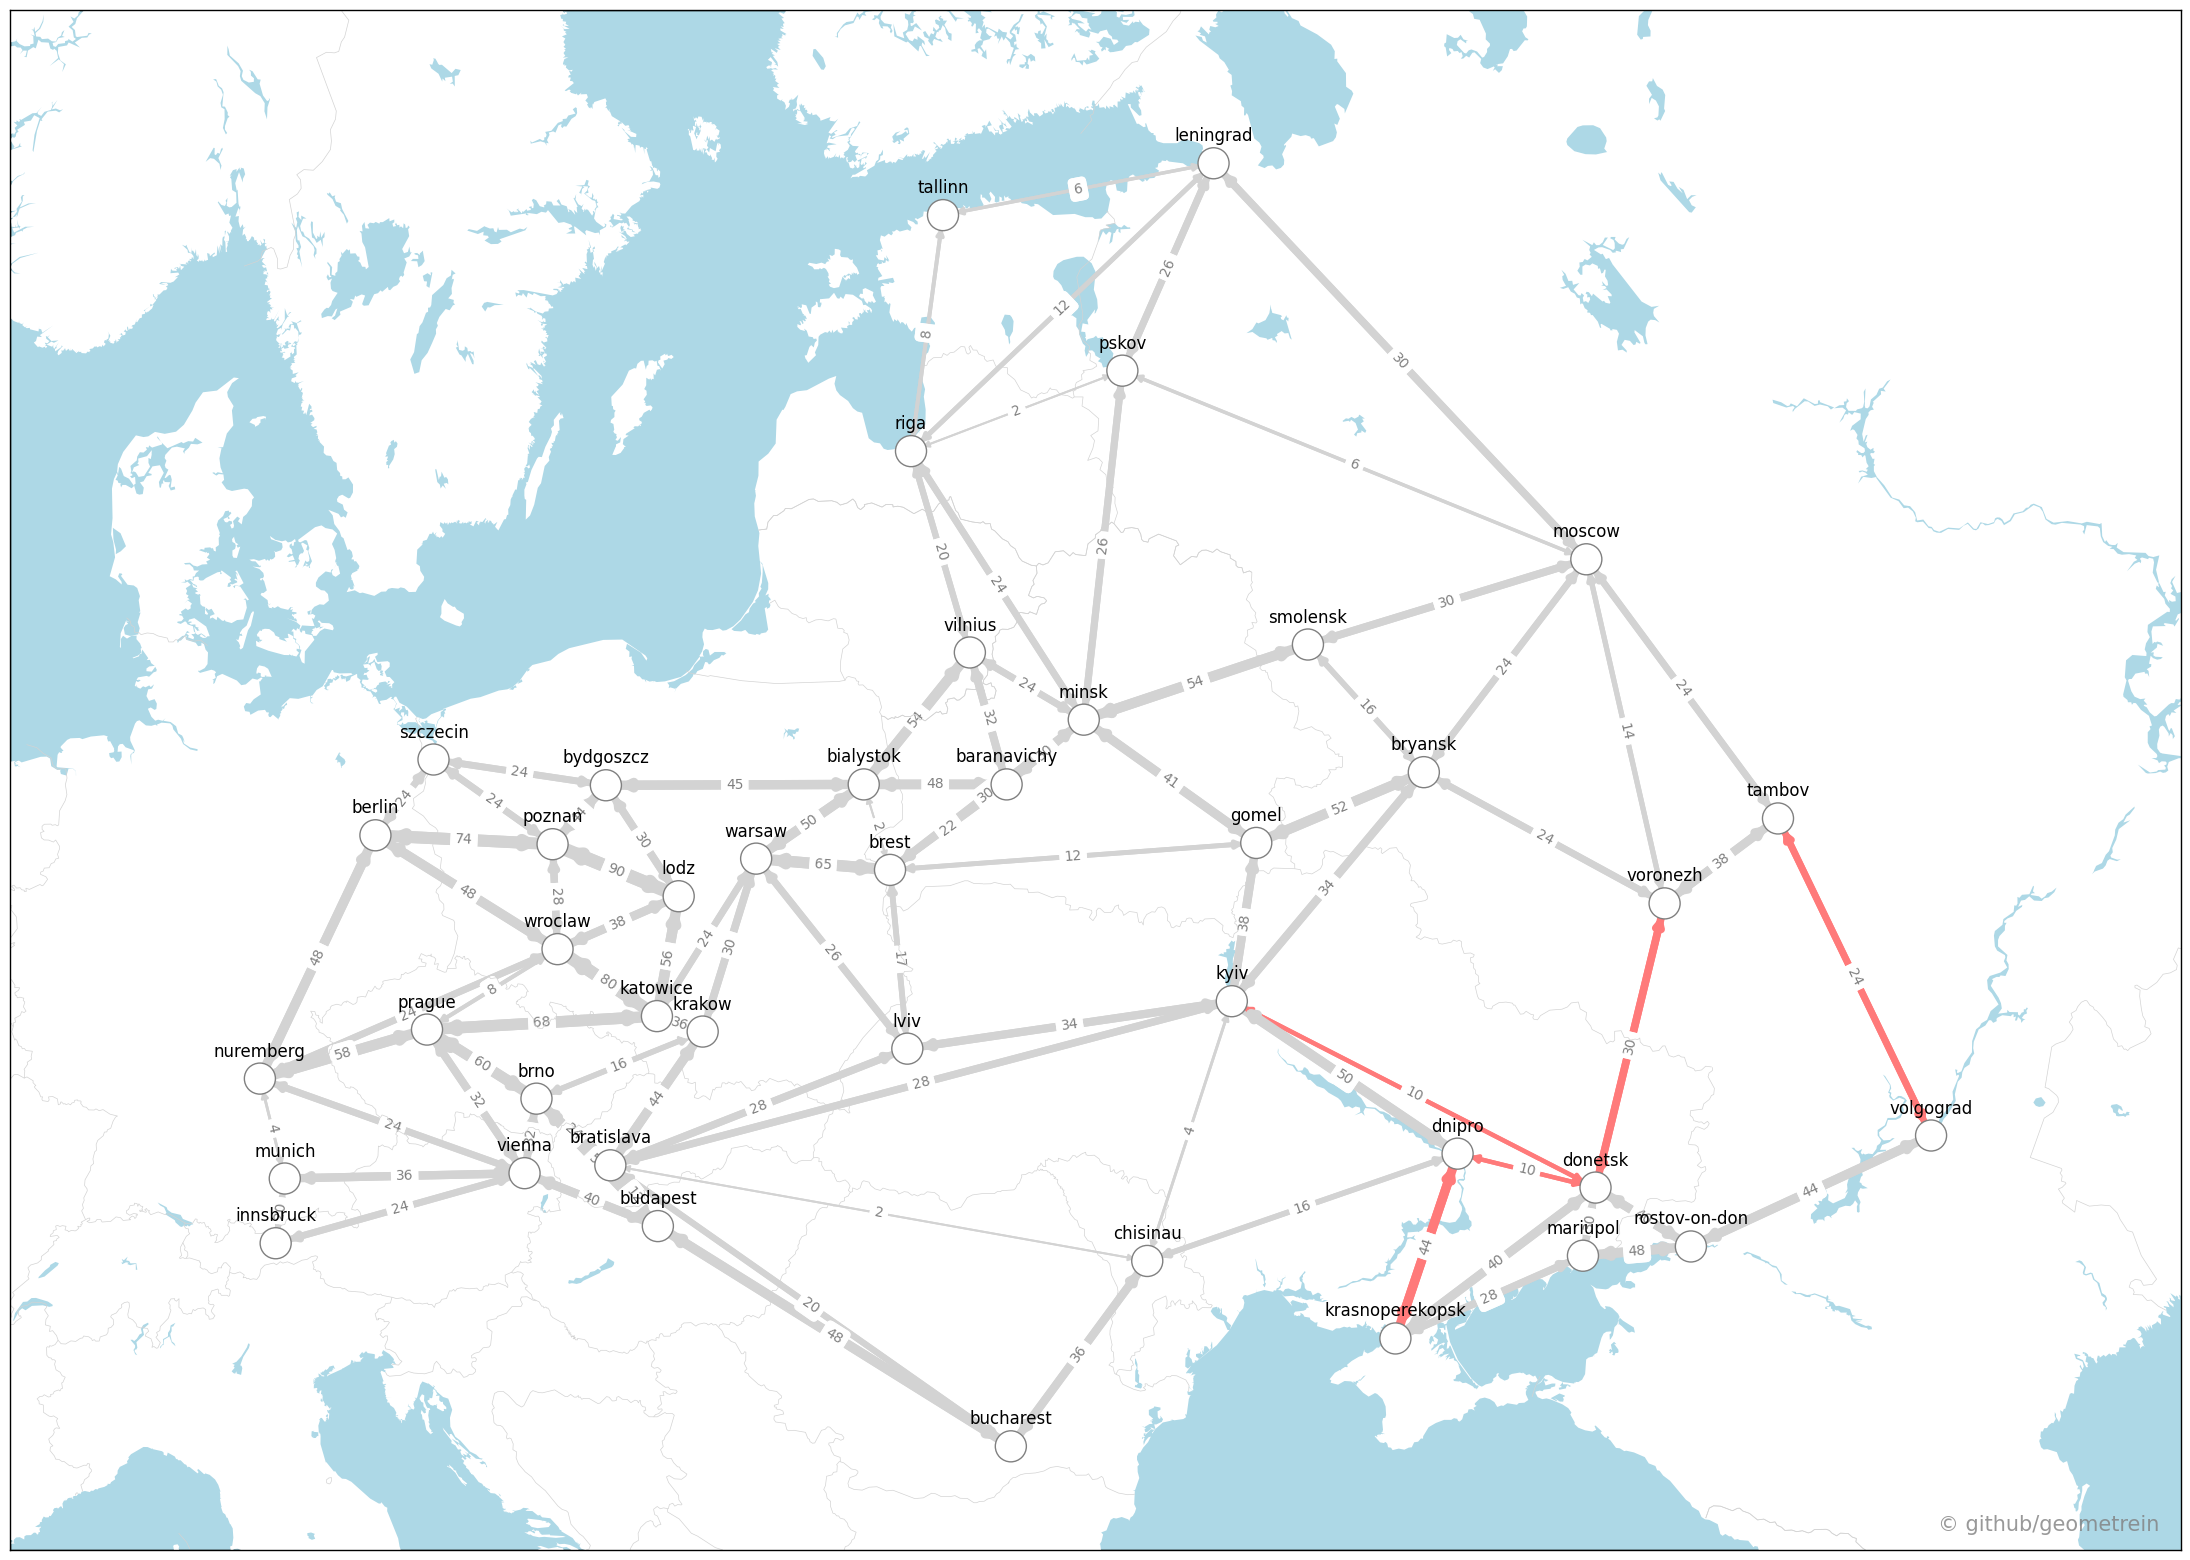

In [25]:
def create_network(G: nx.Graph) -> nx.DiGraph:
    network = nx.DiGraph()
    for u, v, data in G.edges(data=True):
        network.add_edge(u, v, weight=data['weight'])
        network.add_edge(v, u, weight=data['weight'])
    return network


def compute_flow_and_cut(network: nx.DiGraph, source: str, sink: str) -> Tuple[int, Dict[str, Dict[str, int]], Tuple[set, set]]:
    flow_value, flow_dict = nx.maximum_flow(network, source, sink, capacity='weight')
    cut_value_undirected, partition_undirected = nx.minimum_cut(network, source, sink, capacity='weight')
    return flow_value, flow_dict, partition_undirected


def create_color_map(network: nx.DiGraph, reachable_nodes: set) -> List[str]:
    color_map = ['white' if node in reachable_nodes else 'white' for node in network]
    return color_map


def get_node_positions(graph_data: pd.DataFrame) -> Dict[str, Tuple[float, float]]:
    node_positions = {}
    for index, row in graph_data.iterrows():
        if row['source'] not in node_positions:
            node_positions[row['source']] = (row['source_lng'], row['source_lat'])
        if row['target'] not in node_positions:
            node_positions[row['target']] = (row['target_lng'], row['target_lat'])
    return node_positions


def convert_positions_to_map_coords(node_positions: Dict[str, Tuple[float, float]], m: Basemap) -> Dict[str, Tuple[float, float]]:
    return {node: m(lon, lat) for node, (lon, lat) in node_positions.items()}


def draw_network(network: nx.DiGraph, map_positions: Dict[str, Tuple[float, float]], reachable_nodes: set, non_reachable_nodes: set, color_map: List[str]) -> None:
    edge_widths = [data['weight']**(1. / 2) for u, v, data in network.edges(data=True)]
    edge_colors = ['#ff7a7a' if (u in reachable_nodes and v in non_reachable_nodes) or 
                          (u in non_reachable_nodes and v in reachable_nodes) else 'lightgray'
                   for u, v in network.edges()]
    
    nx.draw_networkx_edges(network, pos=map_positions, edge_color=edge_colors, width=edge_widths, arrowsize=10)
    nx.draw_networkx_nodes(network, pos=map_positions, node_color=color_map, node_size=500, edgecolors="grey")
    
    city_label_positions = {key: [value[0], value[1] + 60000] for key, value in map_positions.items()}
    nx.draw_networkx_labels(network, pos=city_label_positions, font_size=12, font_color='black')
    
    edge_labels = {(u, v): f"{data['weight']}" for u, v, data in network.edges(data=True)}
    nx.draw_networkx_edge_labels(network, pos=map_positions, edge_labels=edge_labels, label_pos=0.5, font_size=10, font_color='grey')


def max_flo_min_cut_analysis(G: nx.Graph, graph_data: pd.DataFrame, source: str = 'kiev', sink: str = 'berlin') -> Tuple[int, Dict[str, Dict[str, int]]]:
    network = create_network(G)
    flow_value, flow_dict, partition_undirected = compute_flow_and_cut(network, source, sink)
    reachable_nodes, non_reachable_nodes = partition_undirected
    color_map = create_color_map(network, reachable_nodes)
    node_positions = get_node_positions(graph_data)
    plt.figure(figsize=(60, 20))
    side_padding = 5
    padding = 1.5
    m = Basemap(
        projection='merc', 
        llcrnrlat=min(graph_data['source_lat'].min(), graph_data['target_lat'].min()) - padding, 
        urcrnrlat=max(graph_data['source_lat'].max(), graph_data['target_lat'].max()) + padding,
        llcrnrlon=min(graph_data['source_lng'].min(), graph_data['target_lng'].min()) - side_padding, 
        urcrnrlon=max(graph_data['source_lng'].max(), graph_data['target_lng'].max()) + side_padding,
        resolution='i'
    )
    m.drawcountries(color='lightgrey')
    m.drawmapboundary(fill_color='lightblue')
    m.fillcontinents(color='white', lake_color='lightblue')
    map_positions = convert_positions_to_map_coords(node_positions, m)
    
    draw_network(network, map_positions, reachable_nodes, non_reachable_nodes, color_map)
    
    # Watermark
    plt.annotate(
        '© github/geometrein', 
        xy=(0.99, 0.01), 
        xycoords='axes fraction',
        verticalalignment='bottom', 
        horizontalalignment='right',
        color='grey',
        fontsize=15,
        alpha=0.8
    )
    plt.show()
    return flow_value, flow_dict

flow_value, flow_dict = max_flo_min_cut_analysis(G, graph_data, source='moscow', sink='donetsk')

In [26]:
print(f"Maximum flow value: {flow_value}")
print("Flow along each edge:")
for u, v in flow_dict.items():
    print(f"{u} -> {v}")

Maximum flow value: 118
Flow along each edge:
berlin -> {'szczecin': 0, 'poznan': 0, 'wroclaw': 0, 'nuremberg': 0}
szczecin -> {'berlin': 0, 'bydgoszcz': 0, 'poznan': 0}
poznan -> {'berlin': 0, 'szczecin': 0, 'bydgoszcz': 0, 'wroclaw': 0, 'lodz': 0}
wroclaw -> {'berlin': 0, 'poznan': 0, 'nuremberg': 0, 'prague': 0, 'katowice': 0, 'lodz': 0}
nuremberg -> {'berlin': 0, 'wroclaw': 0, 'vienna': 0, 'munich': 0, 'prague': 0}
bydgoszcz -> {'szczecin': 0, 'poznan': 0, 'lodz': 0, 'bialystok': 0}
lodz -> {'poznan': 0, 'wroclaw': 0, 'bydgoszcz': 0, 'katowice': 0}
prague -> {'wroclaw': 0, 'nuremberg': 0, 'brno': 3, 'vienna': 0, 'katowice': 0}
katowice -> {'wroclaw': 0, 'lodz': 0, 'warsaw': 0, 'krakow': 0, 'prague': 3}
vienna -> {'nuremberg': 0, 'budapest': 3, 'brno': 0, 'munich': 0, 'prague': 0, 'innsbruck': 0}
munich -> {'nuremberg': 0, 'vienna': 0, 'innsbruck': 0}
bialystok -> {'bydgoszcz': 0, 'warsaw': 4, 'vilnius': 0, 'baranavichy': 0, 'brest': 0}
warsaw -> {'bialystok': 0, 'brest': 4, 'lviv':

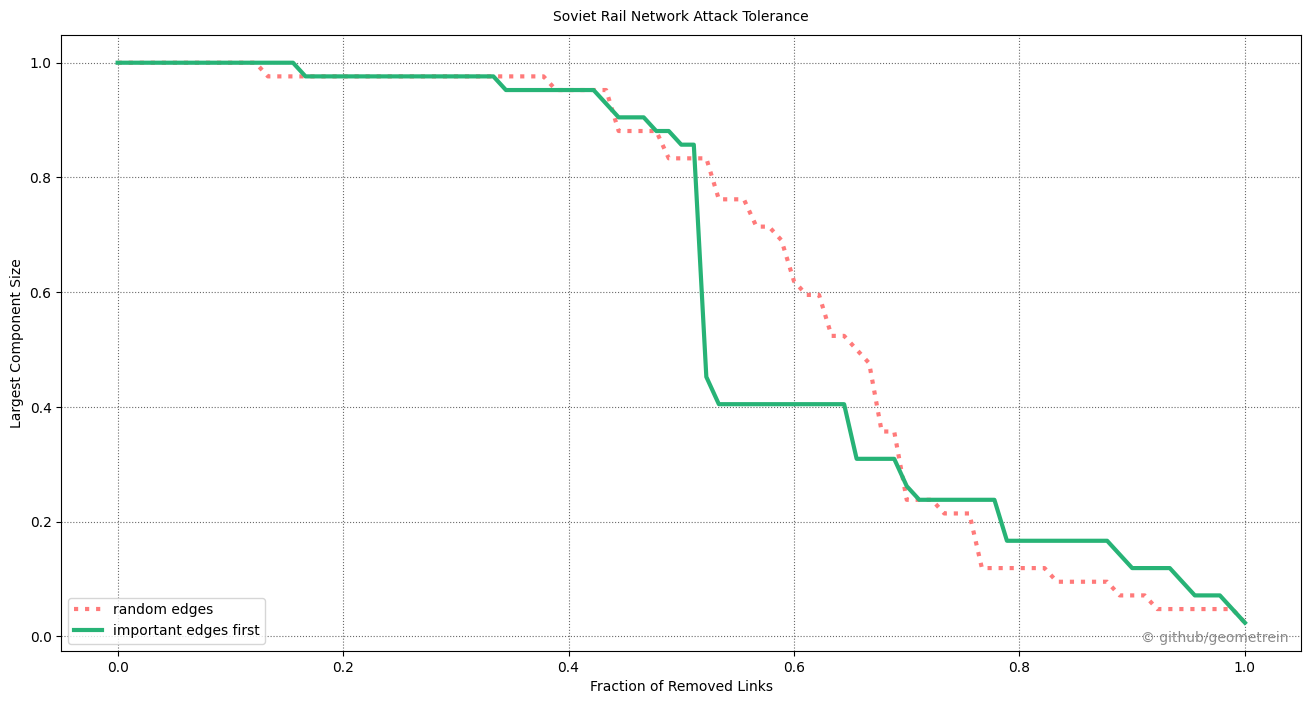

In [27]:
def get_giant_size_component_edges(G: nx.Graph) -> int:
    components = (G.subgraph(c) for c in nx.algorithms.components.connected_components(G))
    return max(map(len, components))


def simulate_edge_removal(orignet: nx.Graph, order: List[Tuple]) -> List[int]:
    giant_sizes = []
    net = orignet.copy()
    for edge in order:
        net.remove_edge(*edge)
        giant_size = get_giant_size_component_edges(net)
        giant_sizes.append(giant_size)
    return giant_sizes


def run_link_removal(G: nx.Graph) -> plt.Figure:
    network = G.copy()
    edges = list(network.edges())
    # Define edge removal orders
    random_edge_order = edges.copy()
    random.shuffle(random_edge_order)
    
    weights = {edge: G.degree[edge[0]] + G.degree[edge[1]] for edge in edges}
    nx.set_edge_attributes(network, weights, "weight")

    ascending_weight_edge_order = sorted(edges, key=lambda edge: network.edges[edge]['weight'])
    descending_weight_edge_order = list(reversed(ascending_weight_edge_order))
    
    # Edge removal and plotting:
    orders = [
        (random_edge_order, 'random edges', "#ff7a7a", ":", 3),
        (descending_weight_edge_order, 'important edges first', "#27b376", "-", 3),
    ]
    
    fig, ax = plt.subplots(figsize=(16, 8))
    for order, order_name, color, ls, lw in orders:
        giant_sizes = simulate_edge_removal(network, order)
        fracs = np.linspace(0, 1, len(giant_sizes))
        ax.plot(fracs, np.array(giant_sizes) / float(len(network.nodes())), color=color, ls=ls, lw=lw, label=order_name)
    
    ax.set_ylabel('Largest Component Size', fontsize=10)
    ax.set_xlabel('Fraction of Removed Links', fontsize=10)
    ax.grid(linestyle=":", color='#696969')
    ax.set_title('Soviet Rail Network Attack Tolerance', fontsize=10, pad=10)
    ax.legend(loc='lower left')

    # Watermark
    ax.text(0.99, 0.01, '© github/geometrein',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=10,
            alpha=0.9)
    
    return fig


fig = run_link_removal(G.to_undirected())

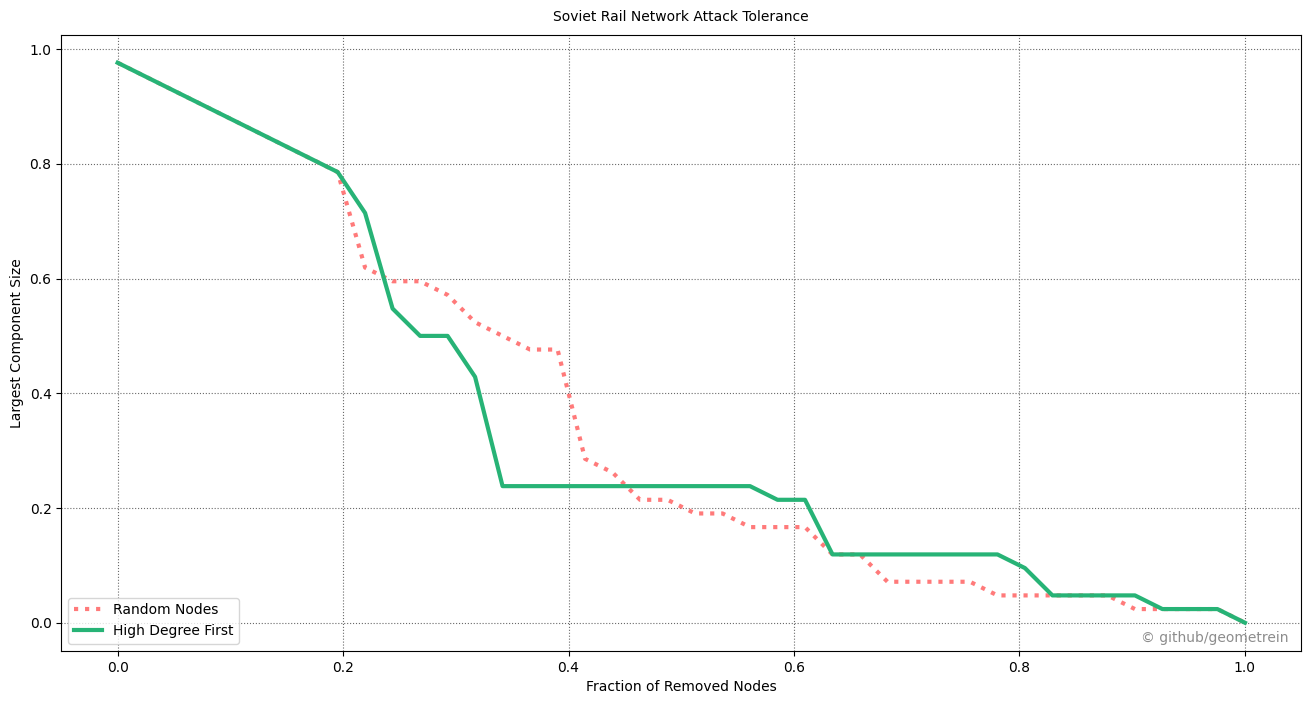

In [28]:
def get_giant_size_component_nodes(G: nx.Graph) -> int:
    largest_cc = [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
    return largest_cc[0] if largest_cc else 0

def simulate_node_removal(G: nx.Graph, order: List[int]) -> List[int]:
    giant_sizes = []
    network = G.copy()
    for node in order:
        if node in network.nodes():
            network.remove_node(node)
            giant_size = get_giant_size_component_nodes(network)
            giant_sizes.append(giant_size)
    return giant_sizes

def run_node_removal(G: nx.Graph) -> plt.Figure:
    network = G.copy()
    nodes = list(network.nodes())
    # Define node removal orders
    random_node_order = nodes.copy()
    random.shuffle(random_node_order)
    descending_degree_node_order = sorted(network.degree, key=lambda x: x[1], reverse=True)
    descending_degree_node_order_nodes = [x[0] for x in descending_degree_node_order]
    # Node removal and plotting:
    orders = [
        (random_node_order, 'Random Nodes', "#ff7a7a", ":", 3),
        (descending_degree_node_order_nodes, 'High Degree First', "#27b376", "-", 3),
    ]
    fig, ax = plt.subplots(figsize=(16, 8))
    for order, order_name, color, ls, lw in orders:
        giant_sizes = simulate_node_removal(network, order)
        fracs = np.linspace(0, 1, len(giant_sizes))
        ax.plot(fracs, np.array(giant_sizes) / float(len(network.nodes())), color=color, ls=ls, lw=lw, label=order_name)
    
    ax.set_ylabel('Largest Component Size', fontsize=10)
    ax.set_xlabel('Fraction of Removed Nodes', fontsize=10)
    ax.grid(linestyle=":", color='#696969')
    ax.set_title('Soviet Rail Network Attack Tolerance', fontsize=10, pad=10)
    ax.legend(loc='lower left')

    # Watermark
    ax.text(0.99, 0.01, '© github/geometrein',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=10,
            alpha=0.9)
    
    return fig

fig = run_node_removal(G.to_undirected())